In [2]:
import numpy as np
import pandas as pd

import os
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import swifter

/Users/congningni/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set(rc={"figure.dpi":300})
sns.set_theme(style="whitegrid")


In [3]:
from scipy.ndimage.filters import gaussian_filter1d
import bisect


<ipython-input-3-8ca35dc3df13>:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [4]:
%matplotlib inline

# Sentiment Changes - TalkingPoint


In [5]:
tp_df = pd.read_csv('../../../Spring2023/TalkingPoint/Coding/Data/LIWC2015 Results (TP_amia_update.csv).csv')

In [6]:
tp_df.columns = ['User_id', 'User_registed_time',
        'Post_time',  'Thread_sort','Thread_id', 'Top_author','Clear_text','Forum','VADER_compound','Tone']
ac_df = pd.read_csv('./Dataset/LIWC2015 Results (AMIA_valid_posts_clear.csv).csv')
ac_df.columns = ['Post_id','User_id', 'User_registed_time','Post_time',  'Thread_sort','Thread_id', 'Top_author','Clear_text','VADER_compound','Forum','Tone']
valid_posts = tp_df.append(ac_df)

In [9]:
valid_posts.Forum.value_counts()

TalkingPoint    1002721
AlzConnected     532992
Name: Forum, dtype: int64

In [10]:
valid_posts['User_registed_time'] = pd.to_datetime(valid_posts.User_registed_time)
valid_posts['Post_time'] = pd.to_datetime(valid_posts.Post_time)


In [11]:
valid_ac = valid_posts[valid_posts.Forum == 'AlzConnected']
valid_tp = valid_posts[valid_posts.Forum == 'TalkingPoint']

In [12]:
valid_tp = valid_tp[valid_tp.User_registed_time >= pd.to_datetime("2011-11-14")]
valid_tp['Post_time'] = valid_tp.Post_time.swifter.apply(lambda x: x.replace(tzinfo=None))

## Statistics

In [17]:
ac_1 = valid_ac.groupby(['Thread_id'])['Clear_text'].count().reset_index()
ac_1['Count of comments per thread'] = ac_1.Clear_text
tp_1 = valid_tp.groupby(['Thread_id'])['Clear_text'].count().reset_index()
tp_1['Count of comments per thread'] = tp_1.Clear_text


In [18]:
ac_2 = valid_ac.groupby('User_id')['Clear_text'].count().reset_index()
ac_2['Count of posts per author'] = ac_2.Clear_text
tp_2 = valid_tp.groupby('User_id')['Clear_text'].count().reset_index()
tp_2['Count of posts per author'] = tp_2.Clear_text

In [19]:
sns.color_palette().as_hex()

['#4c72b0',
 '#dd8452',
 '#55a868',
 '#c44e52',
 '#8172b3',
 '#937860',
 '#da8bc3',
 '#8c8c8c',
 '#ccb974',
 '#64b5cd']

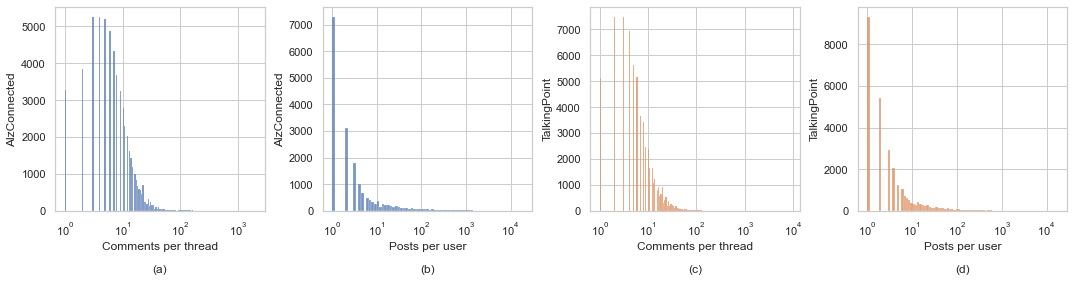

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=False)
#fig.suptitle("Count of submissions per user monthly by subreddits (2019 - 2022) ",fontsize=15,fontweight='bold')
sns.histplot(x='Count of comments per thread', data=ac_1,ax=axes[0],log_scale=True)
axes[0].set(ylabel='AlzConnected', xlabel='Comments per thread\n\n(a)')
#axes[0].set_title("r/lonely")
#axes[0].legend(loc='upper right',title='year')
#axes[0].legend_.remove()

sns.histplot(x='Count of comments per thread', data=tp_1,ax=axes[2], log_scale=True, color='#dd8452')
axes[2].set(ylabel='TalkingPoint',xlabel='Comments per thread\n\n(c)')
#axes[1].set_title("r/ForeverAlone")
#axes[1].legend_.remove()

sns.histplot(x='Count of posts per author', data=ac_2,ax=axes[1],log_scale=True)
axes[1].set(ylabel='AlzConnected',xlabel='Posts per user\n\n(b)')
#axes[0].set(ylabel='Count of submissions per user')
#axes[0].set_title("r/lonely")
#axes[0].legend(loc='upper right',title='year')
#axes[0].legend_.remove()

sns.histplot(x='Count of posts per author', data=tp_2,ax=axes[3], log_scale=True, color='#dd8452')
axes[3].set(ylabel='TalkingPoint',xlabel='Posts per user\n\n(d)')
#axes[1].set(ylabel='')
#axes[1].set_title("r/ForeverAlone")
#axes[1].legend_.remove()
plt.tight_layout (pad=1)

## Topics with top author replies

In [167]:
self_reply_topic = valid_posts[(valid_posts.Top_author == valid_posts.User_id) & (valid_posts.Thread_sort != 1)].Thread_id.drop_duplicates().to_list()
reply_topics = valid_posts[valid_posts.Thread_id.isin(self_reply_topic)]
self_reply_posts = valid_posts[(valid_posts.Top_author == valid_posts.User_id) & (valid_posts.Thread_sort != 1)]


In [171]:
print(self_reply_posts[self_reply_posts.Forum == 'AlzConnected'].shape)
print(self_reply_posts[self_reply_posts.Forum == 'TalkingPoint'].shape)

(81179, 11)
(145993, 11)


## Sentiment Changes

In [174]:
senti_ave = [1,2,3,4,5,6,7,8,9]


### Overall from top post to self comments

In [176]:
df_senti = reply_topics[reply_topics.Thread_sort == 1][['User_id','Post_time', 'Thread_sort','Thread_id', 'Top_author', 
                                                        'Clear_text', 'Forum', 'VADER_compound', 'Tone']]
#df_senti.columns = ['topic_id','post_id','content','user_id','Relationship','VADER_topic']

In [178]:
senti_ave = [1,2,3,4,5,6,7,8,9]

for i in senti_ave:
    temp_shortcom = self_reply_posts[['Thread_id','VADER_compound','Thread_sort','Tone']]
    top_i_replies = temp_shortcom.sort_values(by='Thread_sort').reset_index(drop=True).groupby('Thread_id').head(i)
    top_i_vader = top_i_replies.groupby('Thread_id')['VADER_compound'].mean().reset_index()
    top_i_vader.columns = ['Thread_id','VADER_com_ave%d'%i]
    top_i_liwc = top_i_replies.groupby('Thread_id')['Tone'].mean().reset_index()
    top_i_liwc.columns = ['Thread_id','LIWC_tone_ave%d'%i]
    df_senti = pd.merge(df_senti, top_i_vader,how='left',on='Thread_id')
    df_senti = pd.merge(df_senti, top_i_liwc,how='left',on='Thread_id')

In [179]:
df_topave = pd.DataFrame(columns=['Thread_id','VADER_com_ave','LIWC_Tone_ave','TopN','Forum'])
for i in senti_ave:
    temp_shortcom = self_reply_posts[['Thread_id','VADER_compound','Tone','Thread_sort','Forum']]
    top_i_replies = temp_shortcom.sort_values(by='Thread_sort').reset_index(drop=True).groupby('Thread_id').head(i)
    top_i_vader = top_i_replies.groupby(['Thread_id','Forum'])['VADER_compound','Tone'].mean().reset_index()
    top_i_vader.columns = ['Thread_id','Forum','VADER_com_ave','LIWC_Tone_ave']
    top_i_vader['TopN'] = i
    df_topave = df_topave.append(top_i_vader)

In [180]:
temp = df_senti[['Thread_id','Forum','VADER_compound','Tone']]
temp['TopN'] = 0
temp.columns = ['Thread_id','Forum','VADER_com_ave','LIWC_Tone_ave','TopN']
df_topave = df_topave.append(temp)
df_topave = df_topave.reset_index(drop=True)

<ipython-input-180-9275cd18ae0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['TopN'] = 0


### Pair-wise t-test

In [103]:
import scipy.stats as stats

In [184]:
df_sample_num = [500,1000,2000,5000,7000,10000,20000,30000]

for k in df_sample_num:
    temp_df = df_senti.sample(k,random_state=1)
    print("Sample size - %d"%k, "; P value - %.10f"%stats.ttest_rel(temp_df.VADER_compound,temp_df.VADER_com_ave6).pvalue)

Sample size - 500 ; P value - 0.0000000000
Sample size - 1000 ; P value - 0.0000000000
Sample size - 2000 ; P value - 0.0000000000
Sample size - 5000 ; P value - 0.0000000000
Sample size - 7000 ; P value - 0.0000000000
Sample size - 10000 ; P value - 0.0000000000
Sample size - 20000 ; P value - 0.0000000000
Sample size - 30000 ; P value - 0.0000000000


In [185]:
df_sample_num = [500,1000,2000,5000,7000,10000,20000,30000]

for k in df_sample_num:
    temp_df = df_senti.sample(k,random_state=1)
    print("Sample size - %d"%k, "; P value - %.10f"%stats.ttest_rel(temp_df.VADER_compound,temp_df.LIWC_tone_ave5).pvalue)

Sample size - 500 ; P value - 0.0000000000
Sample size - 1000 ; P value - 0.0000000000
Sample size - 2000 ; P value - 0.0000000000
Sample size - 5000 ; P value - 0.0000000000
Sample size - 7000 ; P value - 0.0000000000
Sample size - 10000 ; P value - 0.0000000000
Sample size - 20000 ; P value - 0.0000000000
Sample size - 30000 ; P value - 0.0000000000


### STM

In [289]:
df_stm = df_senti[['User_id', 'Post_time', 'Thread_sort', 'Thread_id', 'Top_author',
       'Clear_text', 'Forum', 'VADER_compound', 'Tone', 'VADER_com_ave1',
       'LIWC_tone_ave1']]

In [294]:
df_stm['VADER_change'] = df_stm.VADER_com_ave1 - df_stm.VADER_compound
df_stm['LIWC_tone_change'] = df_stm.LIWC_tone_ave1 - df_stm.Tone

<ipython-input-294-9d487b9172a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stm['VADER_change'] = df_stm.VADER_com_ave1 - df_stm.VADER_compound
<ipython-input-294-9d487b9172a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stm['LIWC_tone_change'] = df_stm.LIWC_tone_ave1 - df_stm.Tone


In [337]:
stm_top = pd.read_csv('../../../Spring2023/Cn_Amia/stm20_words_corr.csv')

In [338]:
stm_top_prob = stm_top[stm_top.Metric == 'prob']
stm_top_prob = stm_top_prob.sort_values(by='Corrlation',ascending=False)
stm_top_prob['Topic'] = stm_top_prob.Topic.swifter.apply(lambda x: '# '+x.split(' ')[-1].zfill(2))

In [355]:
test = df_stm.Clear_text.to_list()
index = [idx for idx, s in enumerate(test) if 'my wife' in s.lower()][0]


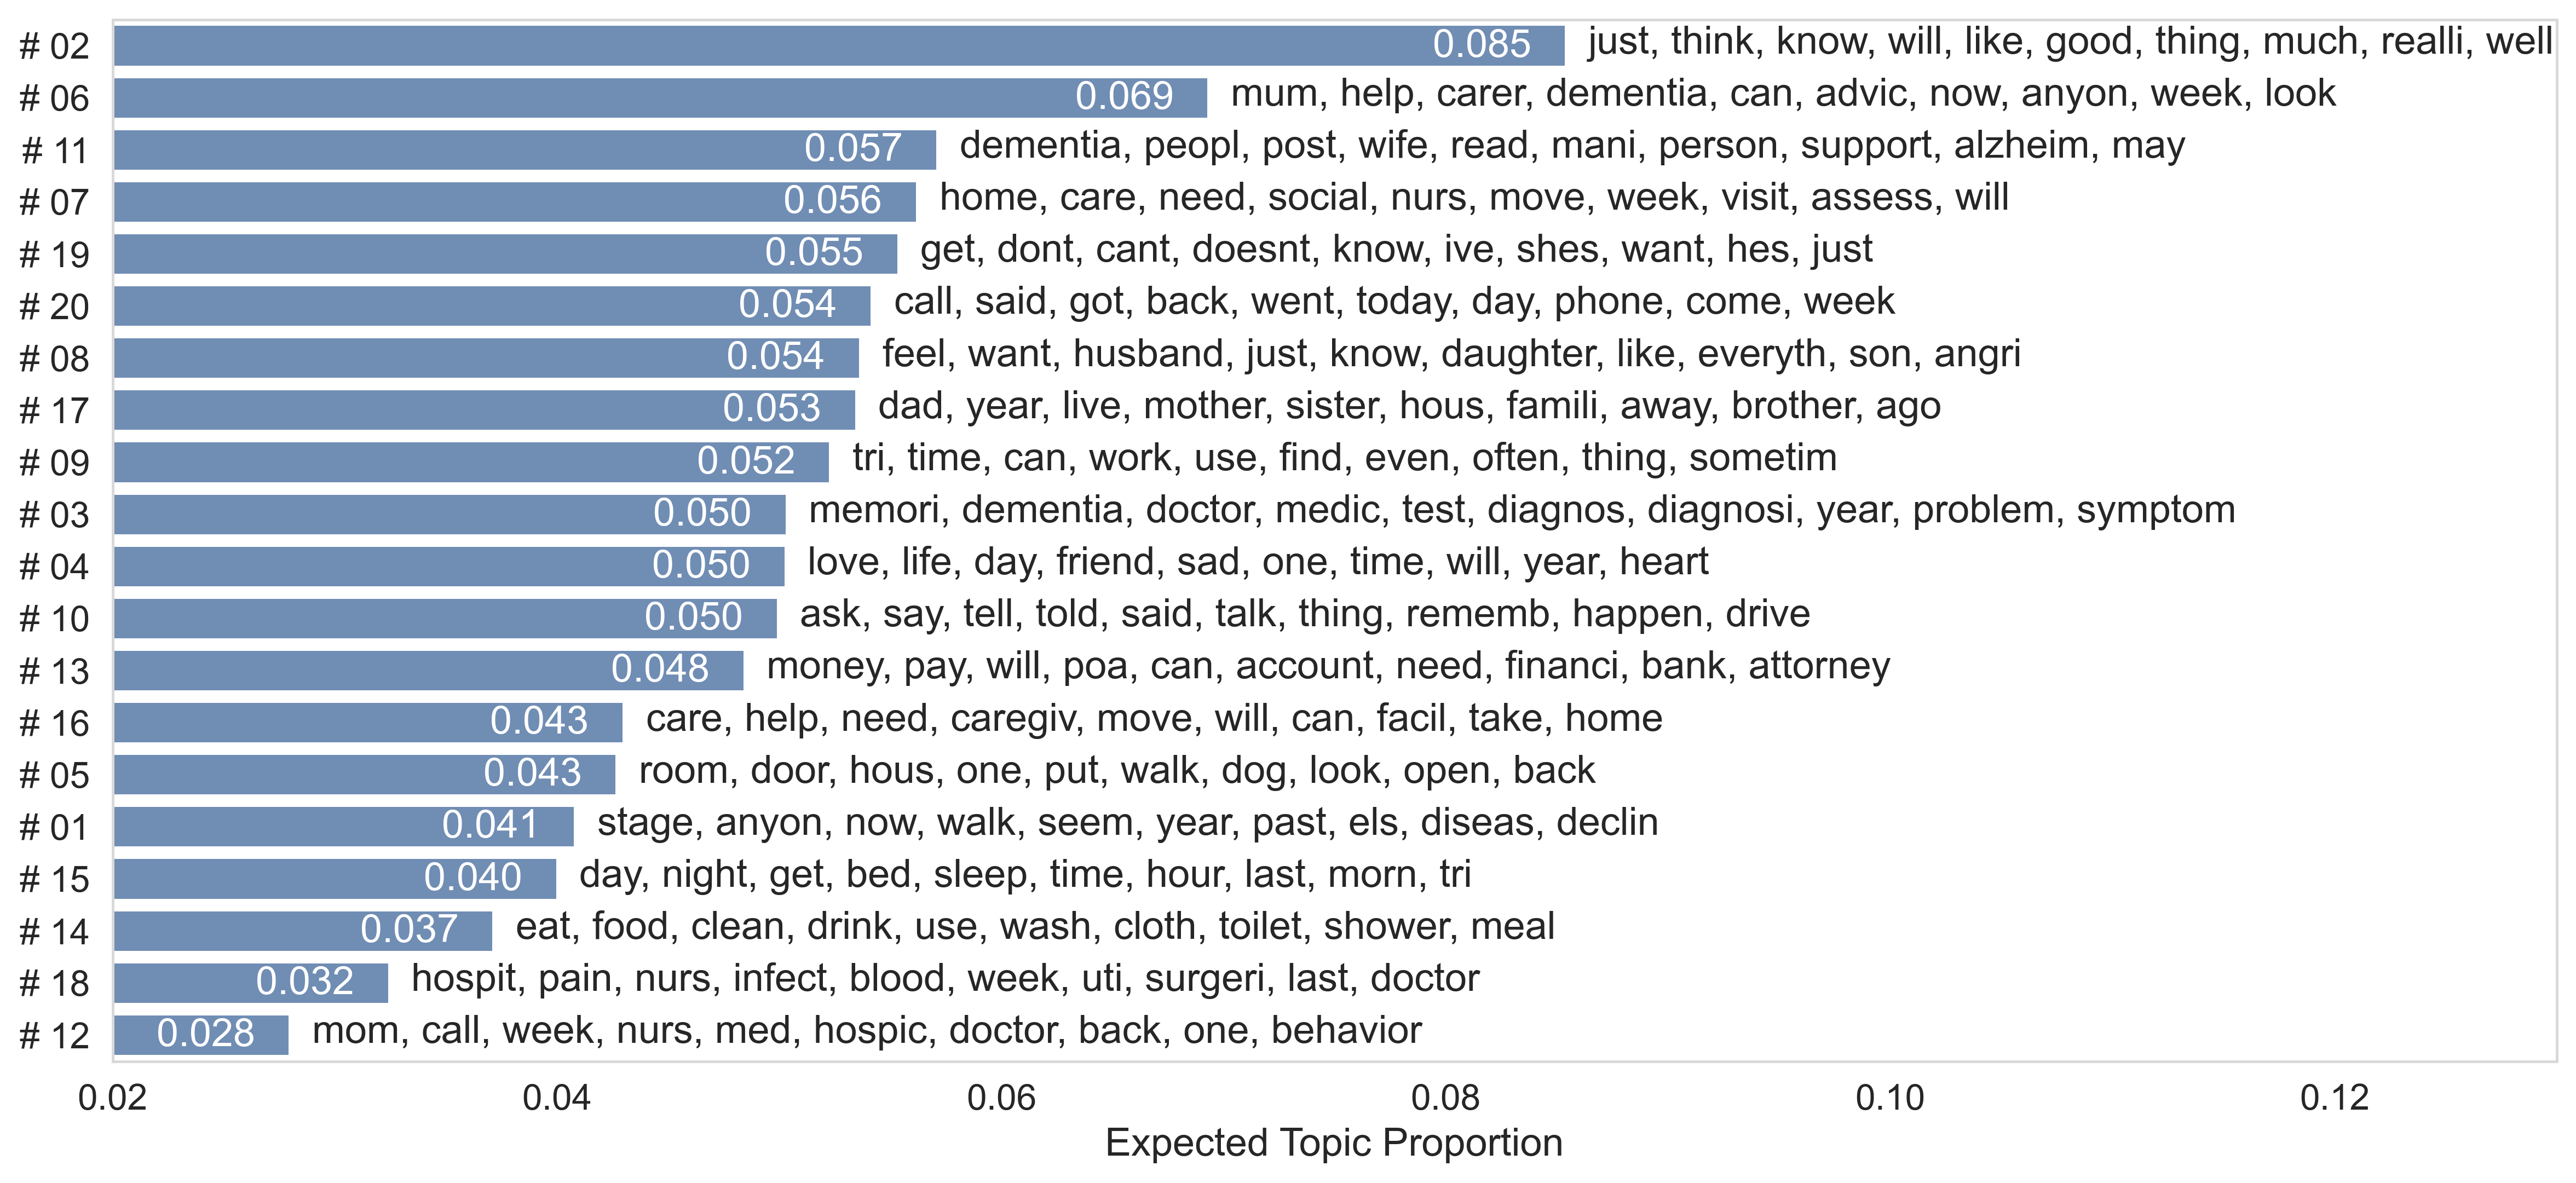

In [354]:
plt.rcParams['figure.dpi'] = 360
plt.figure(figsize =(16, 7))
sns.set_style('white')
sns.set_context("paper", font_scale=1.5) 
#color = ['#658CBF']*4+['#F2AF5C']*5+['#54828C']*3+['#D98F8F']*3
ax = sns.barplot(x='Corrlation', y='Topic', data=stm_top_prob, color='#658CBF')
'''
for i, bar in enumerate(ax.patches):
    bar.set_color("C{}".format(i%2))
'''
plt.ylabel('')
plt.xlabel('Expected Topic Proportion')

ax.spines['right'].set_color('#D9D9D9')
ax.spines['top'].set_color('#D9D9D9')
ax.spines['bottom'].set_color('#D9D9D9')
ax.spines['left'].set_color('#D9D9D9')

#hatches = ['///']*4 + ['+']*5 + ['x']*3 + ['\\']*3
# Loop over the bars
for i,p in enumerate(ax.patches):
    # Set a different hatch for each bar
    #print (i,p)
    #p.set_hatch(hatches[i])
    plt.text(p.get_width()+0.001, p.get_y()+p.get_height()-0.25,
             stm_top_prob['Topic Words'].tolist()[i])
    plt.text(p.get_width()-0.006, p.get_y()+p.get_height()-0.19,
             "%.3f" %round(stm_top_prob.Corrlation.tolist()[i],3),c='white')
             #ha='center', va='center')
plt.xlim(0.02,0.13) 

plt.show()

## Sentiment Timespan - Thread Level

In [55]:
top_posts = reply_topics[reply_topics.Thread_sort == 1].reset_index(drop=True)
top_posts['Relationship'] = top_posts.Relationship_toPersonwithDementia.swifter.apply(lambda x: characters(x))

In [56]:
first_comment = self_reply_posts.sort_values(by='Thread_sort').reset_index(drop=True).groupby('topic_id').head(1)

In [59]:
top_first = top_posts.append(first_comment.drop(columns=['Top_user'])).reset_index(drop=True)

In [60]:
df_tf_update = top_first.sort_values(by=['topic_id','Timespan']).reset_index(drop=True)
df_tf_update['Timerange'] = df_tf_update.Timespan.diff()

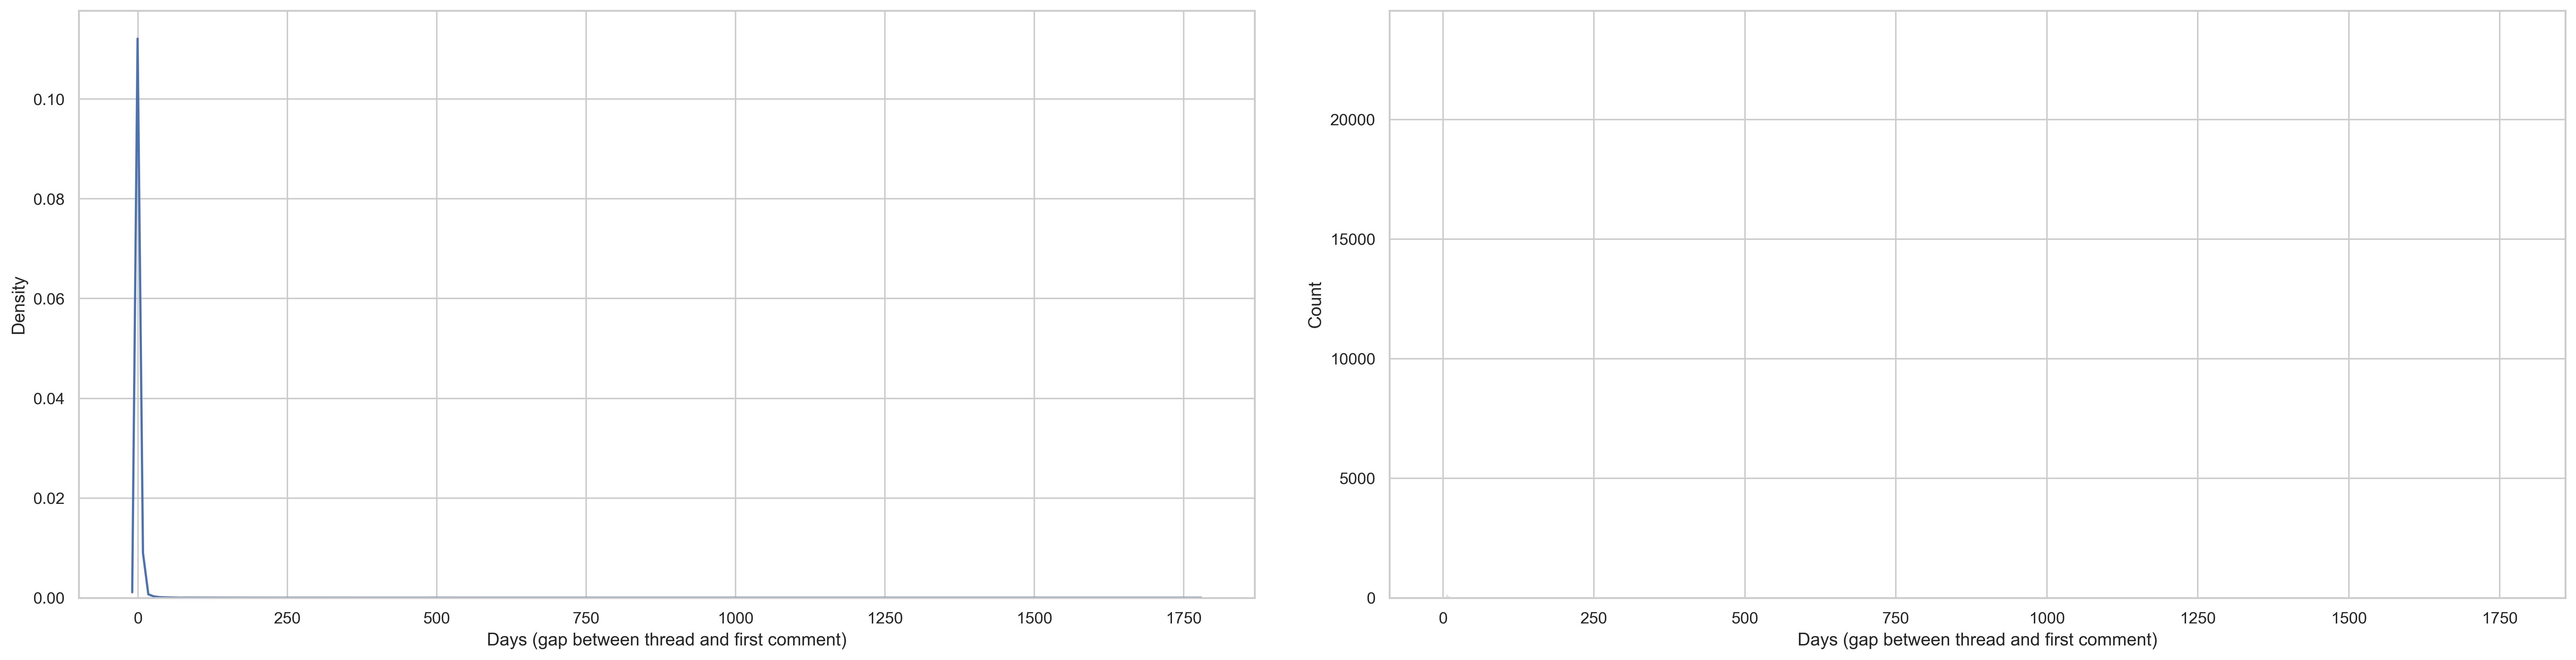

In [61]:
temp_tf = df_tf_update[df_tf_update.Top_user.isna()].reset_index(drop=True)
temp_tf['Days (gap between thread and first comment)'] = temp_tf.Timerange.swifter.apply(lambda x: x.days)
fig, axes = plt.subplots(1, 2, figsize=(25, 7), sharey=False)
#fig.suptitle("Count of submissions per user monthly by subreddits (2019 - 2022) ",fontsize=15,fontweight='bold')

sns.kdeplot(x='Days (gap between thread and first comment)', data=temp_tf,ax=axes[0], palette='Set2')
#axes[0].set(ylabel='Count of submissions per user')
#axes[0].set_title("r/lonely")
#axes[0].legend(loc='upper right',title='year')
#axes[0].legend_.remove()

sns.histplot(x='Days (gap between thread and first comment)', data=temp_tf,ax=axes[1], palette='Set2')
#axes[1].set(ylabel='')
#axes[1].set_title("r/ForeverAlone")
#axes[1].legend_.remove()
plt.tight_layout (pad=3)

In [62]:
df_first_comment = df_tf_update[df_tf_update.Top_user.isna()][['topic_id','user_id','VADER_compound','Timespan','Relationship','Timerange']]
temp_time = df_tf_update[df_tf_update.Thread_sort == 1][['topic_id','user_id','VADER_compound','Timespan','Relationship']]
#temp_time['Timerange'] = pd.to_timedelta("0 days")
temp_time.columns = ['topic_id','user_id','Ori_VADER','Timespan','Relationship']

In [63]:
df_timegap = pd.merge(df_first_comment,temp_time, on=['topic_id','user_id','Relationship'])

In [64]:
df_timegap['Score_diff'] = df_timegap.VADER_compound - df_timegap.Ori_VADER

In [65]:
df_timegap['Gap Days'] = df_timegap.Timerange.swifter.apply(lambda x: x.days)

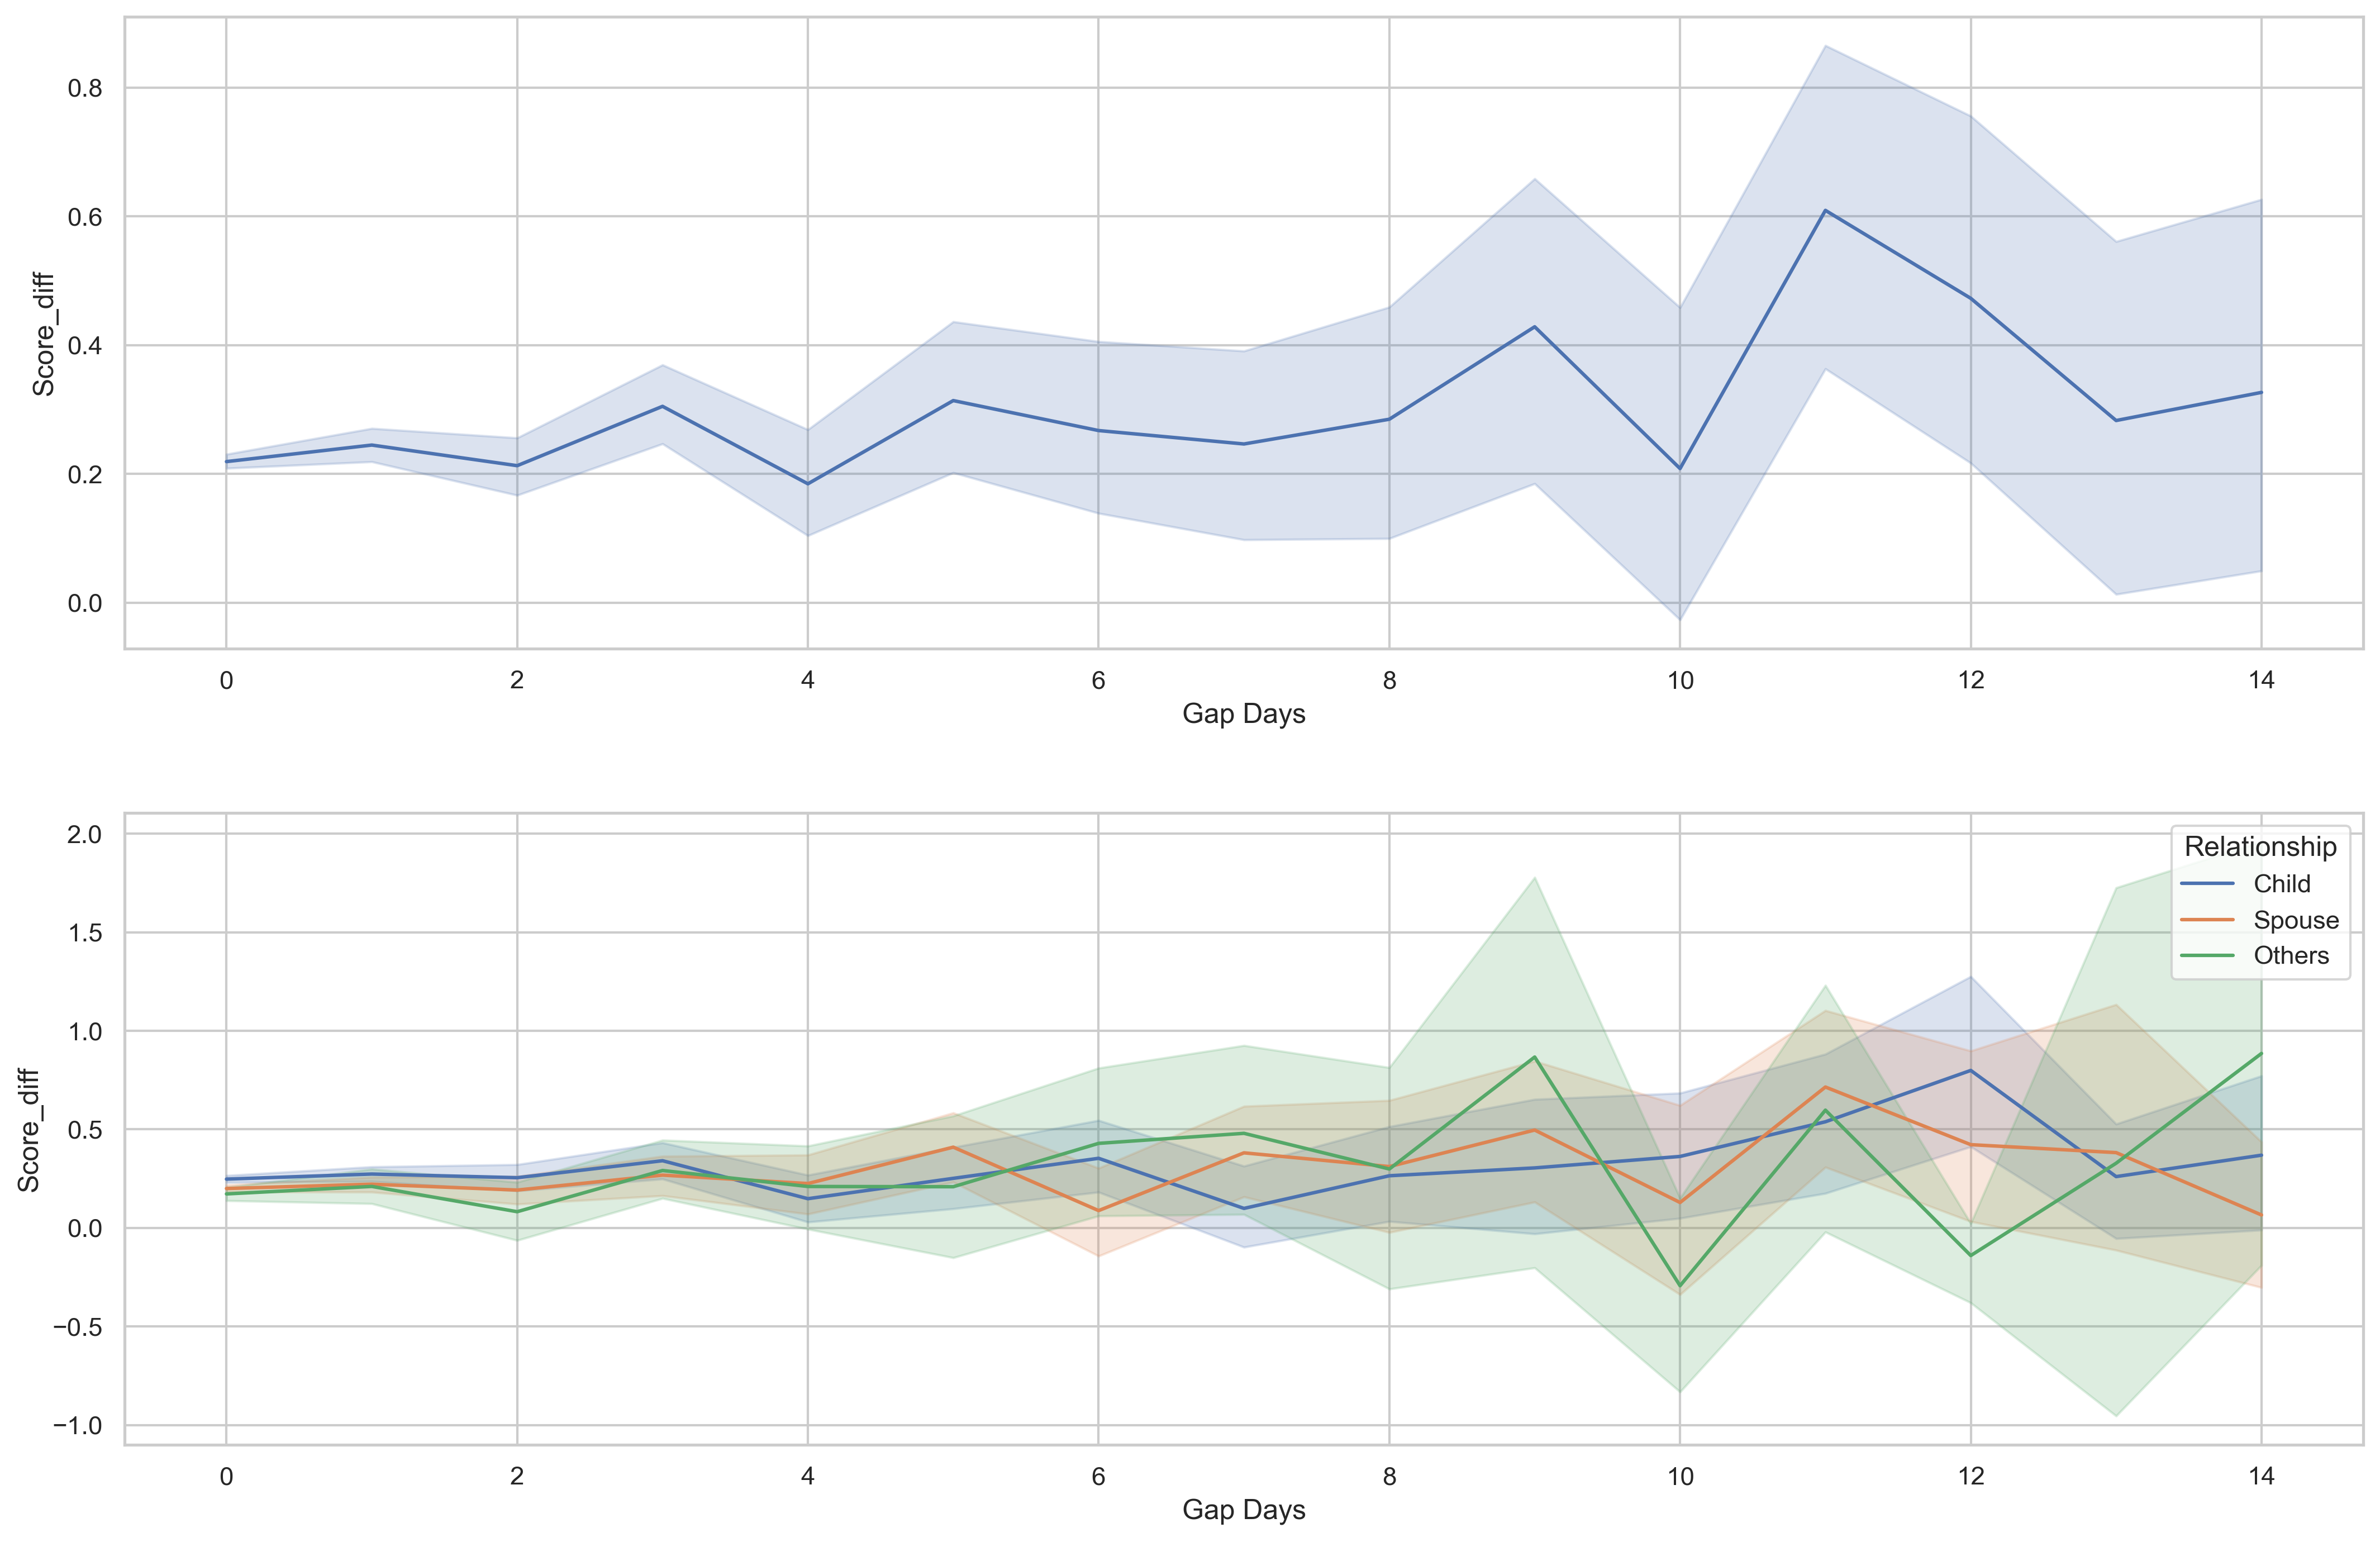

In [67]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
#fig.suptitle("Count of submissions per user monthly by subreddits (2019 - 2022) ",fontsize=15,fontweight='bold')

sns.lineplot(x='Gap Days',y='Score_diff',data=df_timegap[df_timegap['Gap Days']<=14], ax=axes[0])#axes[0].set(ylabel='Count of submissions per user')
#axes[0].set_title("r/lonely")
#axes[0].legend(loc='upper right',title='year')
#axes[0].legend_.remove()

sns.lineplot(x='Gap Days',y='Score_diff',data=df_timegap[df_timegap['Gap Days']<=14], hue='Relationship', ax=axes[1])
#axes[1].set(ylabel='')
#axes[1].set_title("r/ForeverAlone")
#axes[1].legend_.remove()
plt.tight_layout (pad=3)

#sns.lineplot(x='Gap Days',y='Score_diff',data=df_timegap[df_timegap['Gap Days']<=14], hue='Relationship')

## Sentiment Timespan - User Level

In [189]:
temp_user = valid_posts.groupby(['User_id'])['Clear_text'].count().reset_index()
multi_post_users = temp_user[temp_user.Clear_text >1].User_id.to_list()
tripo_post_users = temp_user[temp_user.Clear_text >2].User_id.to_list()

In [190]:
multi_post_user_df = valid_posts[valid_posts.User_id.isin(multi_post_users)]
multi_post_user_df = multi_post_user_df[['Clear_text','User_id','Forum','VADER_compound','Tone','Post_time']]

In [191]:
tripo_post_user_df = valid_posts[valid_posts.User_id.isin(tripo_post_users)]
tripo_post_user_df = tripo_post_user_df[['Clear_text','User_id','Forum','VADER_compound','Tone','Post_time']]

In [192]:
valid_posts.Post_time.astype(str)

0          2018-02-22 12:27:00
1          2018-02-22 20:24:00
2          2020-04-01 23:29:00
3          2020-04-02 01:24:00
4          2020-04-02 06:31:00
                  ...         
1002716    2022-10-23 08:23:55
1002717    2022-10-23 17:03:01
1002718    2022-10-29 22:24:12
1002719    2022-10-29 23:29:13
1002720    2022-10-30 08:25:36
Name: Post_time, Length: 1114207, dtype: object

In [88]:
df_user_group = multi_post_user_df.copy()
temp4 = df_user_group.sort_values(by='Timespan').drop_duplicates(subset='user_id')
temp4.columns = ['first_post_id','first_content','user_id','first_time','first_VADER','Relationship','first_sort']
df_user_group = pd.merge(df_user_group, temp4, how='left',on=['user_id','Relationship'])

In [90]:
df_user_group['Post_timegap'] = df_user_group.apply(lambda x: (x.Timespan - x.first_time).days, axis=1)
temp5 = df_user_group.sort_values(by='Post_timegap', ascending=False).drop_duplicates(subset='user_id')[['user_id','Post_timegap']]
temp5.columns = ['user_id','longest_gap']
df_user_group = pd.merge(df_user_group,temp5,how='left',on='user_id')

In [92]:
user_group01 = df_user_group[(df_user_group.Post_timegap<=7)].reset_index(drop=True)
user_group14 = df_user_group[(df_user_group.longest_gap>7) & (df_user_group.longest_gap<=30) & (df_user_group.Post_timegap<=30)].reset_index(drop=True)
user_group1m3m = df_user_group[(df_user_group.longest_gap>30) & (df_user_group.longest_gap<=90) & (df_user_group.Post_timegap<=90)].reset_index(drop=True)
user_group3m6m = df_user_group[(df_user_group.longest_gap>90) & (df_user_group.longest_gap<=180) & (df_user_group.Post_timegap<=180)].reset_index(drop=True)
user_group6m1y = df_user_group[(df_user_group.longest_gap>180) & (df_user_group.longest_gap<=365) & (df_user_group.Post_timegap<=365)].reset_index(drop=True)
user_group1y3y = df_user_group[(df_user_group.longest_gap>365) & (df_user_group.longest_gap<=1096) & (df_user_group.Post_timegap<=1096)].reset_index(drop=True)
user_group3y5y = df_user_group[(df_user_group.longest_gap>1096) & (df_user_group.longest_gap<=1826) & (df_user_group.Post_timegap<=1826)].reset_index(drop=True)
user_group5y10y = df_user_group[(df_user_group.longest_gap>1826) & (df_user_group.longest_gap<=3653) & (df_user_group.Post_timegap<=3653)].reset_index(drop=True)
user_group10ymore = df_user_group[(df_user_group.longest_gap>3653)].reset_index(drop=True)

##### cut users 
0, 0-1w,0-2w,0-1m,3m,6m,1y,5y,10y
Anyone active at least two post between the window and one over the window

__Registration Date__ cut relative days;
__Days to minutes__

In [95]:
hue_order = ['Child', 'Spouse', 'Others']


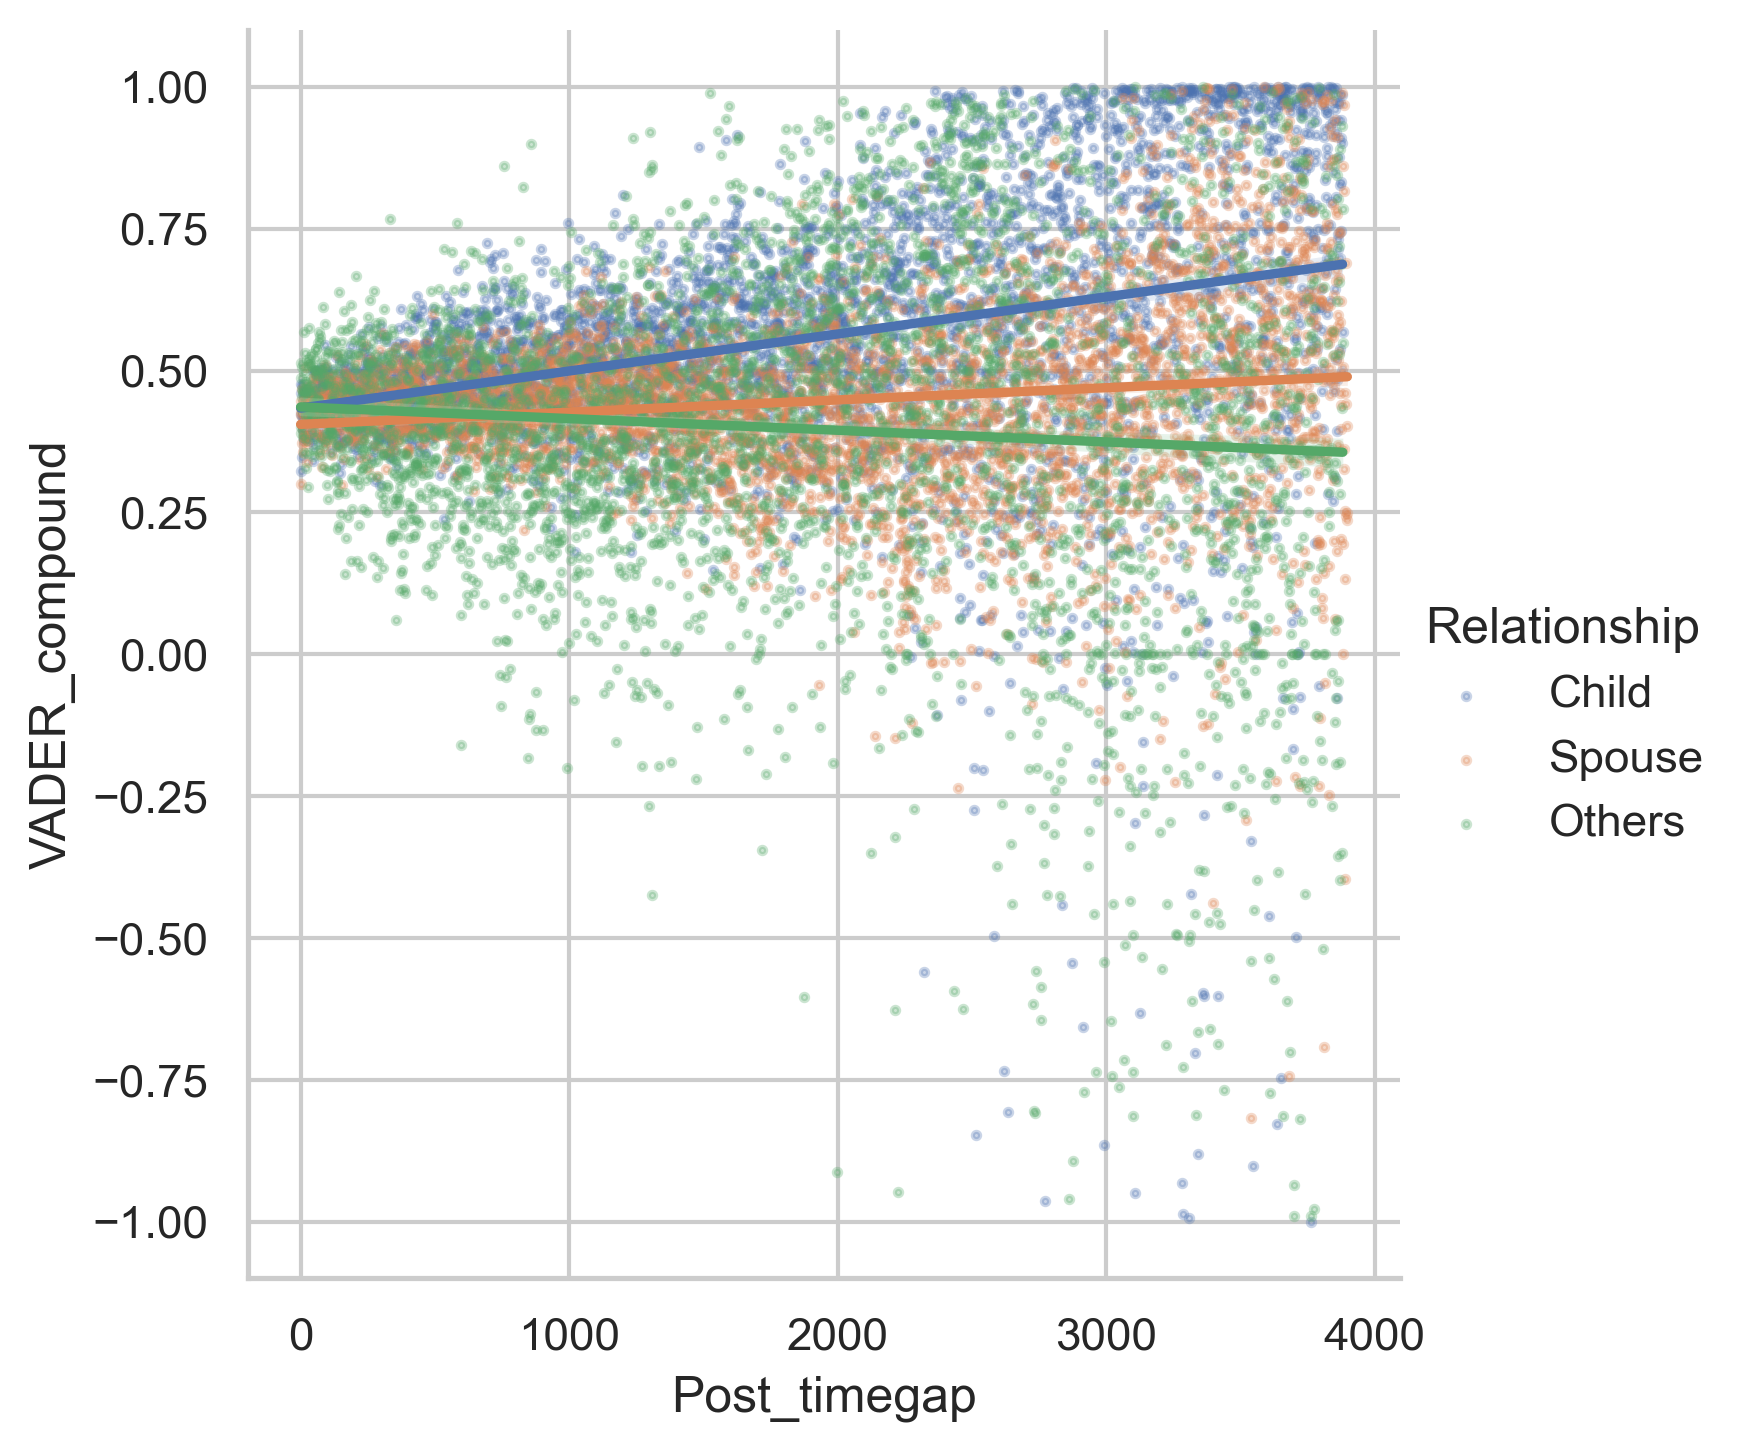

In [96]:
user_group_all = df_user_group[['Post_timegap','VADER_compound','Relationship']]
user_group_all = user_group_all.groupby(['Post_timegap','Relationship'])['VADER_compound'].mean().reset_index()

sns.lmplot(x='Post_timegap',y='VADER_compound',data=user_group_all,hue='Relationship', hue_order=hue_order,
          ci=95,scatter_kws={"s": 3,'alpha': 0.3})#axes[0].set(ylabel='Count of submissions per user')


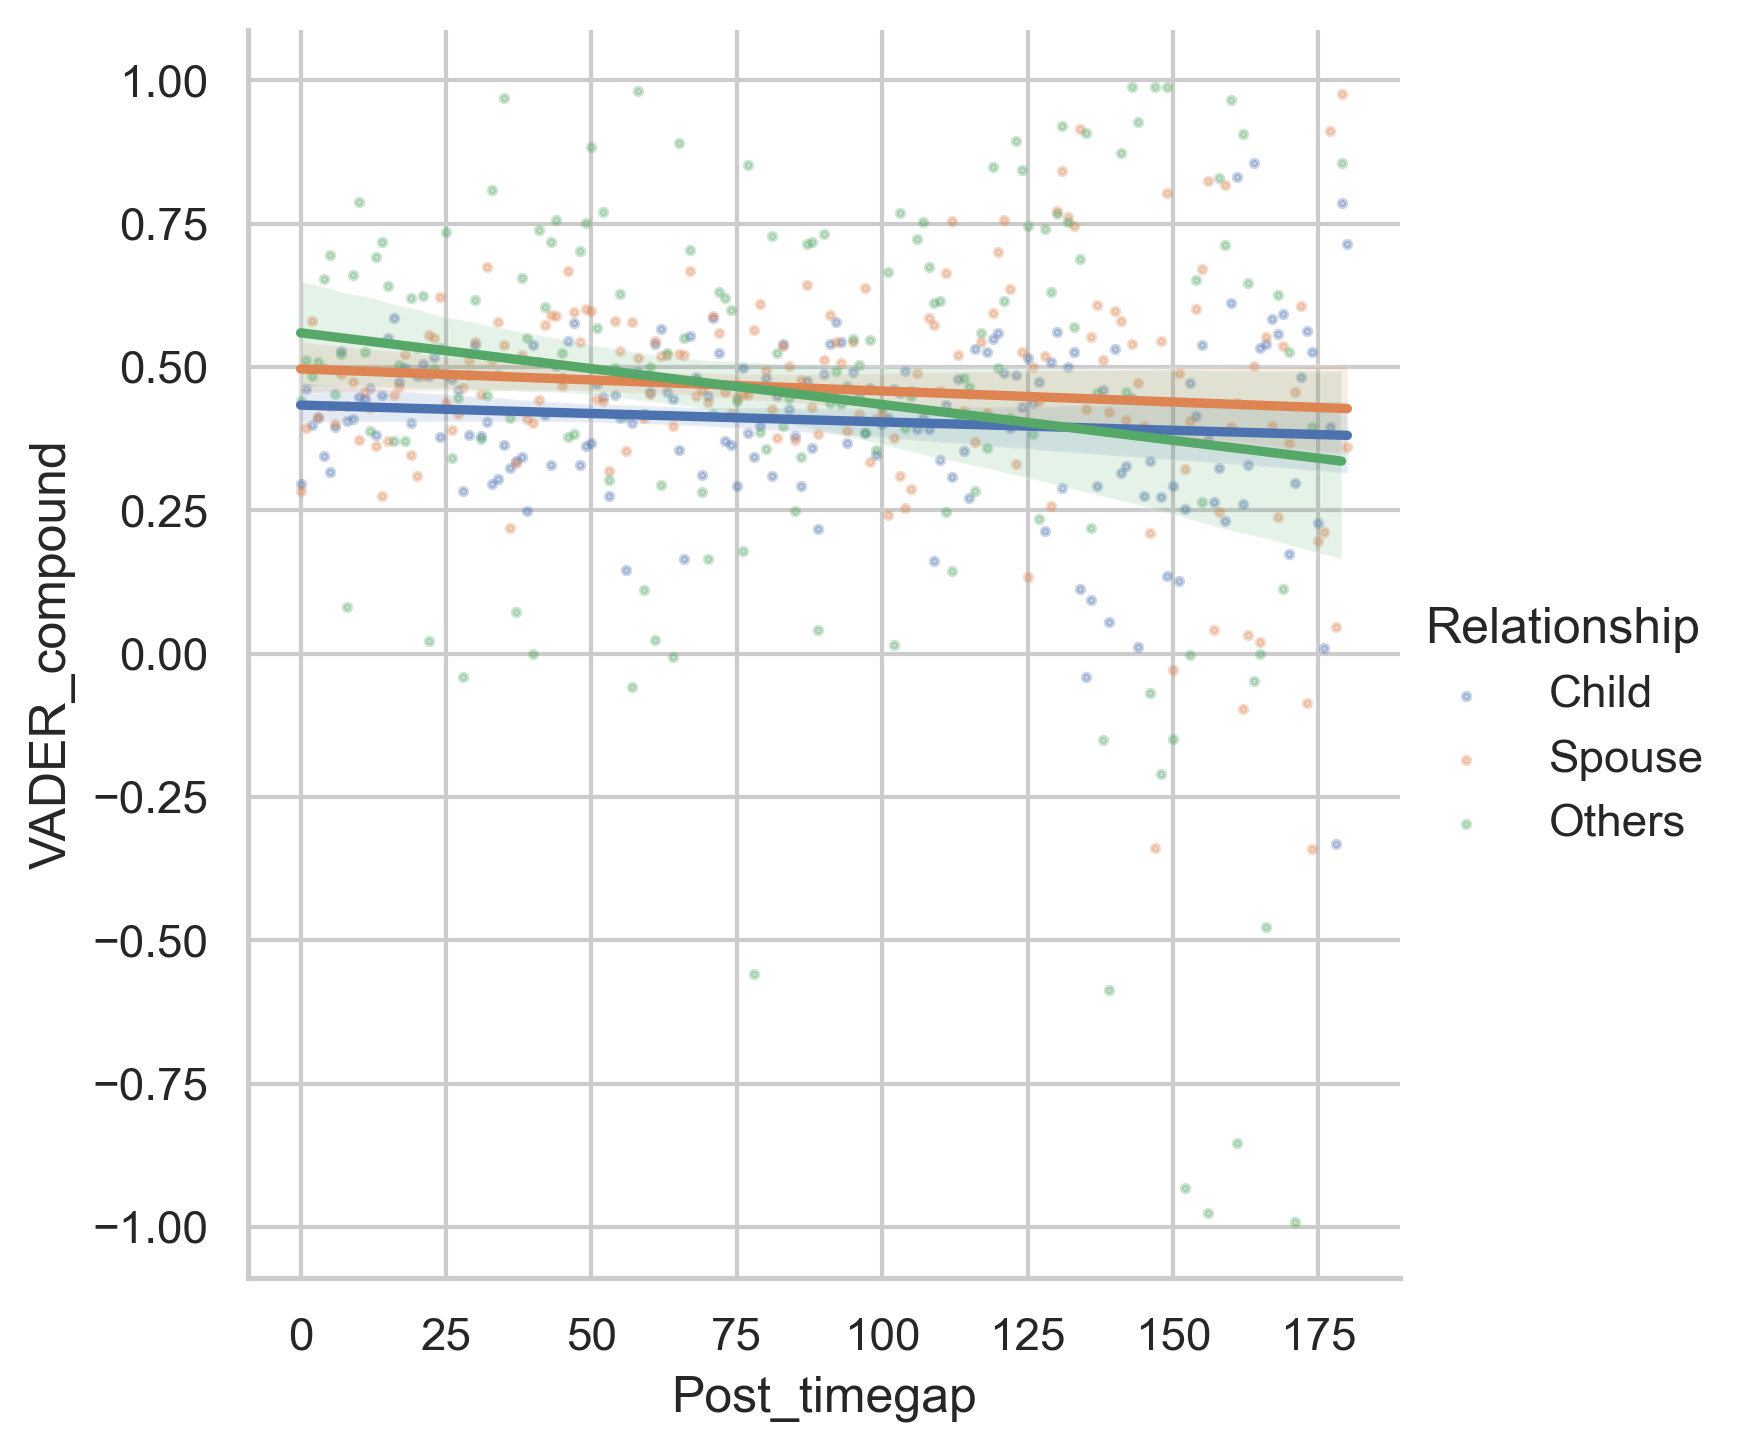

In [100]:
user_group3m6m_mean = user_group3m6m[['Post_timegap','VADER_compound','Relationship']]
user_group3m6m_mean = user_group3m6m_mean.groupby(['Post_timegap','Relationship'])['VADER_compound'].mean().reset_index()

sns.lmplot(x='Post_timegap',y='VADER_compound',data=user_group3m6m_mean,hue='Relationship', hue_order=hue_order,
          ci=95,scatter_kws={"s": 3,'alpha': 0.3})#axes[0].set(ylabel='Count of submissions per user')


### Sentiment span - active users at least 3 times

In [156]:

from datetime import datetime, timezone
 
# Get the datetime object using datetime
# module
dt_obj_w_tz = datetime.now()
print(dt_obj_w_tz)
 
# Add timezone information to the datetime
# object
dt_obj_w_tz = dt_obj_w_tz.replace(tzinfo=timezone.utc)
print(dt_obj_w_tz)
 
# Remove the timezone information from the datetime
# object
dt_obj_wo_tz = dt_obj_w_tz.replace(tzinfo=None)
print(dt_obj_wo_tz)

2023-03-19 01:03:52.886505
2023-03-19 01:03:52.886505+00:00
2023-03-19 01:03:52.886505


In [198]:
from datetime import datetime, timezone

df_user_tripo = tripo_post_user_df.copy()
df_user_tripo['Post_time'] = df_user_tripo.Post_time.swifter.apply(lambda x: x.replace(tzinfo=None))
temp5 = df_user_tripo.sort_values(by='Post_time').drop_duplicates(subset='User_id')


/Users/congningni/opt/anaconda3/lib/python3.8/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


In [199]:
temp5.columns

Index(['Clear_text', 'User_id', 'Forum', 'VADER_compound', 'Tone',
       'Post_time'],
      dtype='object')

In [197]:
df_user_tripo.columns

Index(['Clear_text', 'User_id', 'Forum', 'VADER_compound', 'Tone',
       'Post_time'],
      dtype='object')

In [200]:
temp5.columns = ['first_content','User_id','Forum','first_VADER','first_LIWC','first_time']
df_user_tripo = pd.merge(df_user_tripo, temp5, how='left',on=['User_id','Forum'])

In [202]:
df_user_tripo['Post_timegap'] = df_user_tripo.apply(lambda x: (x.Post_time - x.first_time).total_seconds() / 60, axis=1)
temp5 = df_user_tripo.sort_values(by='Post_timegap', ascending=False).drop_duplicates(subset='User_id')[['User_id','Post_timegap']]


KeyError: 'user_id'

In [204]:
temp5.columns = ['User_id','longest_gap']

df_user_tripo = pd.merge(df_user_tripo,temp5,how='left',on='User_id')

In [205]:
temp6 = df_user_tripo.sort_values(by='Post_timegap').groupby('User_id').agg({'Post_timegap': lambda x: list(x)}).reset_index()
temp6.columns = ['User_id','gap_list']
df_user_tripo = pd.merge(df_user_tripo, temp6, how='left',on='User_id')

In [207]:
def group_selection(df, gapminutes):
    gap_list = df.gap_list
    post_gap = df.Post_timegap
    
    if gap_list[1] <= gapminutes: ## have two posts between the window
        out_window = list(filter(lambda x: x>gapminutes, gap_list))
        if len(out_window) != 0: ## have one element larger than window
            return 1
        else:
            return 0
    else:
        return 0
        

In [208]:
gapminutes = []
for days in [7,14,30.4, 91,182.5,365,1826.2,3652.4]:
    minutes = int(days*24*60)
    #print (minutes)
    gapminutes.append(minutes)
    

In [209]:
for minutes in gapminutes:
    df_user_tripo['Valid_gap_%d'%minutes] = df_user_tripo.apply(lambda x: group_selection(x,minutes), axis=1)

In [238]:
from matplotlib.cm import get_cmap

default_colors = get_cmap('tab10')
palette = {k: default_colors(i) for i, k in enumerate(['a','b'])}

In [247]:
def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    from matplotlib.cm import get_cmap
    
    regplots = []
    
    levels = ['AlzConnected','TalkingPoint']
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],label=key,
                **kwargs
            )
        )
    
    return regplots

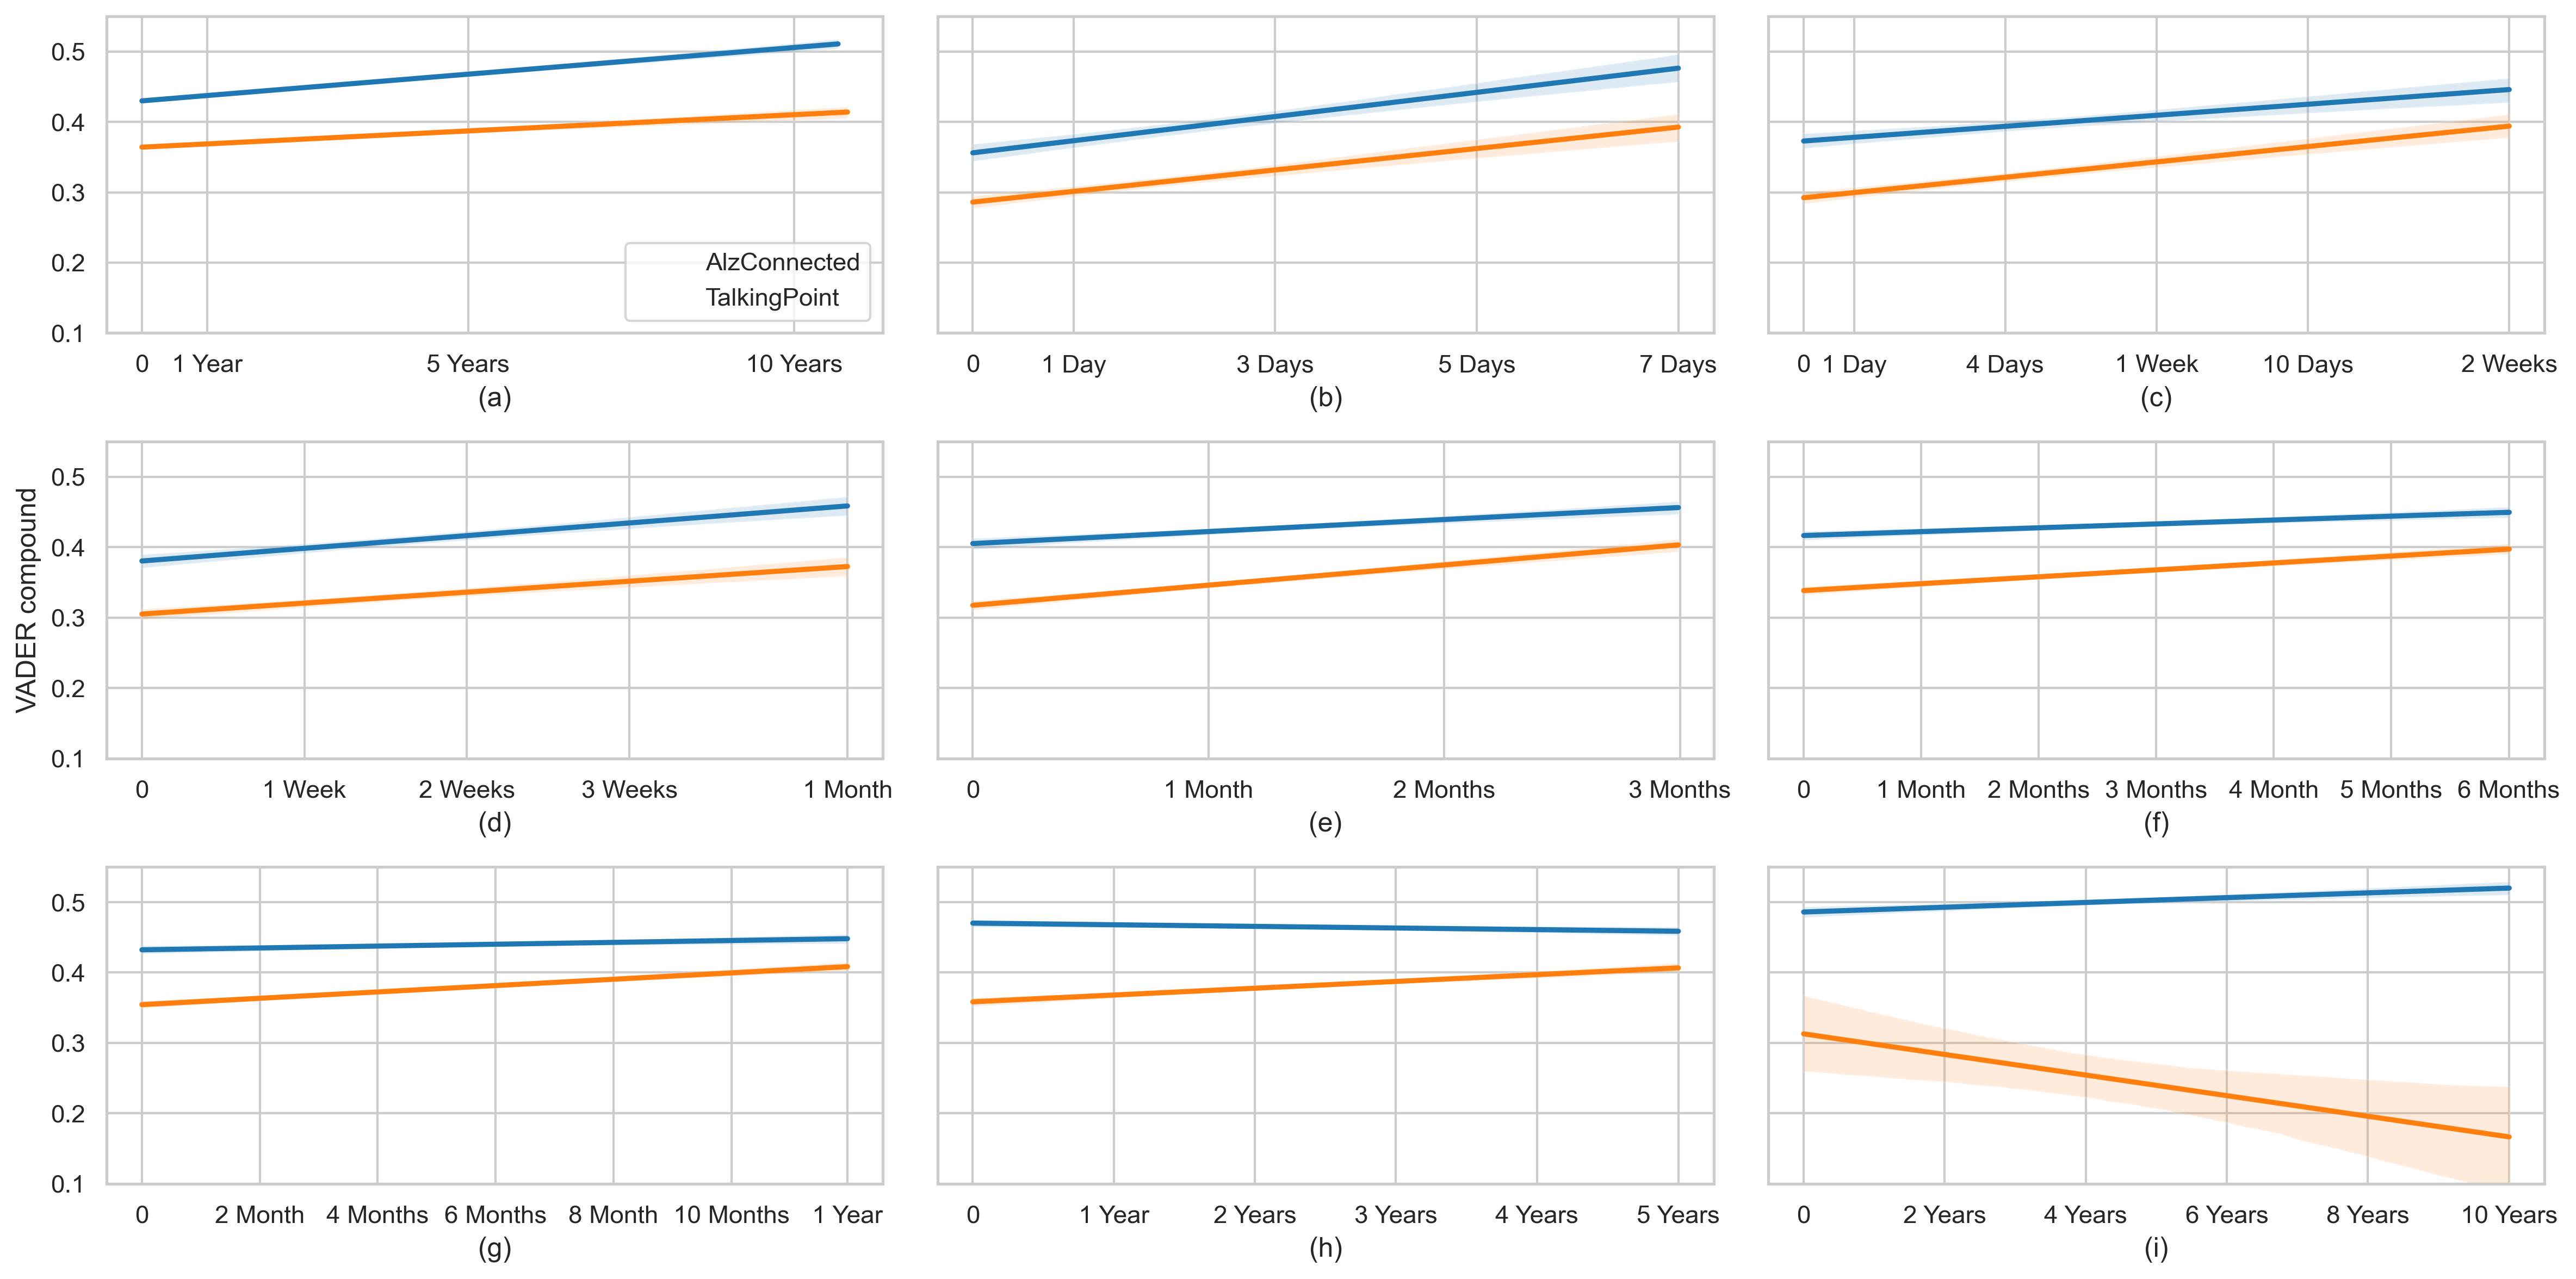

In [269]:
sns.set(rc={"figure.dpi":300})
sns.set_theme(style="whitegrid")

v_low,v_high = 0.1,0.55

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3, sharey=True, figsize=(16,8))
#fig.suptitle('##')

## Overall data points
ax_a = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo, ax=ax1,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_a[1].set_xticks([0,525600, 2629728, 5259456])
ax_a[1].set_xticklabels([0,'1 Year','5 Years','10 Years'])
##shape_a = df_user_tripo.drop_duplicates(subset='user_id').shape[0]
ax_a[1].set(xlabel='(a)', ylabel=None, ylim=(v_low,v_high))
ax_a[1].legend(loc='lower right')

## Within one week
ax_b = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_10080 == 1) & (df_user_tripo.Post_timegap <= 10080)], 
                   ax=ax2,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_b[1].set_xticks([0,1*24*60,3*24*60,5*24*60,7*24*60])
ax_b[1].set_xticklabels([0,'1 Day','3 Days','5 Days','7 Days'])
#ax_b[1].set(xlabel=None, ylabel=None, ylim=(v_low,v_high))
##shape_b = df_user_tripo[(df_user_tripo.Valid_gap_10080 == 1) & (df_user_tripo.Post_timegap <= 10080)].drop_duplicates(subset='user_id').shape[0]
ax_b[1].set(xlabel='(b)', ylabel=None, ylim=(v_low,v_high))

## Within two weeks
ax_c = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_20160 == 1) & (df_user_tripo.Post_timegap <= 20160)], 
                   ax=ax3,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_c[1].set_xticks([0,1*24*60,4*24*60,7*24*60,10*24*60,14*24*60])
ax_c[1].set_xticklabels([0,'1 Day','4 Days','1 Week','10 Days',  '2 Weeks'])
##shape_c = df_user_tripo[(df_user_tripo.Valid_gap_20160 == 1) & (df_user_tripo.Post_timegap <= 20160)].drop_duplicates(subset='user_id').shape[0]
ax_c[1].set(xlabel='(c)', ylabel=None, ylim=(v_low,v_high))

## Within 1 month
ax_d = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_43775 == 1) & (df_user_tripo.Post_timegap <= 43775)], 
                   ax=ax4,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_d[1].set_xticks([0, 7*24*60, 14*24*60, 21*24*60,43775])
ax_d[1].set_xticklabels([0,'1 Week','2 Weeks','3 Weeks', '1 Month'])
#shape_d = df_user_tripo[(df_user_tripo.Valid_gap_43775 == 1) & (df_user_tripo.Post_timegap <= 43775)].drop_duplicates(subset='user_id').shape[0]
ax_d[1].set(xlabel='(d)', ylabel='VADER compound', ylim=(v_low,v_high))


## Within 3 months
ax_e = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_131040 == 1) & (df_user_tripo.Post_timegap <= 131040)], 
                   ax=ax5,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_e[1].set_xticks([0,43775,43775*2,43775*3])
ax_e[1].set_xticklabels([0,'1 Month','2 Months','3 Months'])
#shape_e = df_user_tripo[(df_user_tripo.Valid_gap_131040 == 1) & (df_user_tripo.Post_timegap <= 131040)].drop_duplicates(subset='user_id').shape[0]
ax_e[1].set(xlabel='(e)', ylabel=None, ylim=(v_low,v_high))

## Within 6 months
ax_f = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_262800 == 1) & (df_user_tripo.Post_timegap <= 262800)], 
                   ax=ax6,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_f[1].set_xticks([0,43775,43775*2,43775*3,43775*4,43775*5,43775*6])
ax_f[1].set_xticklabels([0,'1 Month','2 Months','3 Months','4 Month','5 Months','6 Months'])
#shape_f = df_user_tripo[(df_user_tripo.Valid_gap_262800 == 1) & (df_user_tripo.Post_timegap <= 262800)].drop_duplicates(subset='user_id').shape[0]
ax_f[1].set(xlabel='(f)', ylabel=None, ylim=(v_low,v_high))

## Within 1 year
ax_g = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_525600 == 1) & (df_user_tripo.Post_timegap <= 525600)], 
                   ax=ax7,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_g[1].set_xticks([0, 2*30.5*24*60, 4*30.5*24*60,6*30.5*24*60,8*30.5*24*60,10*30.5*24*60,525600])
ax_g[1].set_xticklabels([0,'2 Month','4 Months','6 Months','8 Month','10 Months','1 Year'])
#shape_g = df_user_tripo[(df_user_tripo.Valid_gap_525600 == 1) & (df_user_tripo.Post_timegap <= 525600)].drop_duplicates(subset='user_id').shape[0]
ax_g[1].set(xlabel='(g)', ylabel=None, ylim=(v_low,v_high))

## Within 5 years
ax_h = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_2629728 == 1) & (df_user_tripo.Post_timegap <= 2629728)], 
                   ax=ax8,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_h[1].set_xticks([0,525600, 2*525600, 3*525600, 4*525600, 2629728])
ax_h[1].set_xticklabels([0,'1 Year','2 Years','3 Years','4 Years','5 Years'])
#shape_h = df_user_tripo[(df_user_tripo.Valid_gap_2629728 == 1) & (df_user_tripo.Post_timegap <= 2629728)].drop_duplicates(subset='user_id').shape[0]
ax_h[1].set(xlabel='(h)', ylabel=None, ylim=(v_low,v_high))

## Within 10 years
ax_i = hue_regplot(x='Post_timegap',y='VADER_compound',data=df_user_tripo[(df_user_tripo.Valid_gap_5259456 == 1) & (df_user_tripo.Post_timegap <= 5259456)], 
                   ax=ax9,scatter_kws={"s": 0,'alpha': 0}, hue='Forum')
ax_i[1].set_xticks([0,2*525600, 4*525600, 6*525600, 8*525600, 5259456])
ax_i[1].set_xticklabels([0,'2 Years','4 Years','6 Years','8 Years','10 Years'])
#shape_i = df_user_tripo[(df_user_tripo.Valid_gap_5259456 == 1) & (df_user_tripo.Post_timegap <= 5259456)].drop_duplicates(subset='user_id').shape[0]
ax_i[1].set(xlabel='(i)', ylabel=None, ylim=(v_low,v_high))

plt.tight_layout()

In [299]:
import scipy
scipy.__version__

'1.10.1'

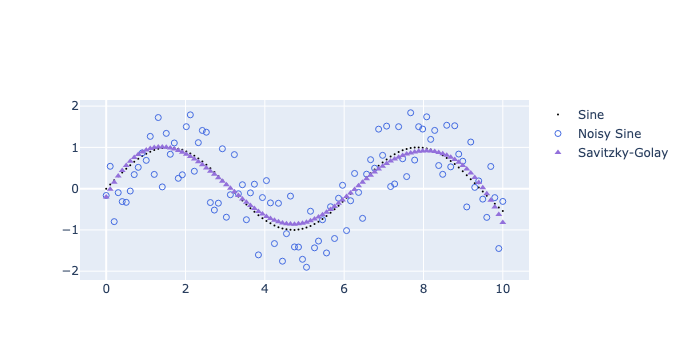

In [106]:
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import scipy

from scipy import signal

np.random.seed(1)

x = np.linspace(0, 10, 100)
y = np.sin(x)
noise = 2 * np.random.random(len(x)) - 1 # uniformly distributed between -1 and 1
y_noise = y + noise

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(size=2, color='black'),
    name='Sine'
))

fig.add_trace(go.Scatter(
    x=x,
    y=y_noise,
    mode='markers',
    marker=dict(
        size=6,
        color='royalblue',
        symbol='circle-open'
    ),
    name='Noisy Sine'
))

fig.add_trace(go.Scatter(
    x=x,
    y=signal.savgol_filter(y,
                           53, # window size used for filtering
                           3), # order of fitted polynomial
    mode='markers',
    marker=dict(
        size=6,
        color='mediumpurple',
        symbol='triangle-up'
    ),
    name='Savitzky-Golay'
))


fig.show()